# Atelier utilisation d'EXIOBASE
Luxembourg Stratégie

## Introduction
(traduite du cours en ligne [IO Models with Python](https://www.openriskacademy.com/course/view.php?id=64))

_Qu'est-ce qu'un modèle d'entrées-sorties (input-output model) ?_

Les tableaux d'entrées-sorties multirégionaux avec extensions environnementales (EEMRIO pour _environmentally-extended multiregional input-output_) décrivent les relations économiques des acteurs économiques (généralement regroupés ou agrégés en secteurs industriels) opérant au sein de régions géographiques.

Outre les liens économiques, les tableaux EE MRIO visent également à prendre en compte les répercussions environnementales de l'activité économique. À cette fin, un système EEMRIO complète les modèles économiques d'entrées-sorties les plus basiques (et historiquement les premiers introduits) avec des ensembles de données et/ou des hypothèses de modélisation supplémentaires, afin de donner un aperçu de l'empreinte environnementale de l'activité économique.

Actuellement, l'accent mis sur les externalités négatives de l'activité économique (par exemple, le changement climatique et la perte de biodiversité induits par l'homme) fait des modèles EE MRIO un outil conceptuel et analytique utile. Une bonne connaissance des modèles d'entrées-sorties sous-jacents est un prérequis et ce sera l'objectif initial de ce cours.

_Définition_

Un modèle d'entrées-sorties est un modèle économique construit à partir de données économiques observées (mesurées) qui fournissent des informations sur l'activité des industries qui produisent et consomment des biens et des services. L'élément central de ces modèles est la matrice (ou le tableau) des entrées-sorties. Cette matrice permet de présenter une analyse détaillée des processus interdépendants de production et d'utilisation (consommation) de biens et de services (produits).

Ces modèles peuvent retracer à la fois les flux de matières et les revenus monétaires générés au cours de ces flux. Les tableaux d'entrées-sorties peuvent se présenter sous la forme de :
- tableaux des ressources et des emplois (TRE) qui relient les produits aux industries ou
- tableaux entrées-sorties symétriques qui relient les produits aux produits ou les industries aux industries.

**Nous nous concentrerons ici sur les tables symétriques.**

## Installation

Ce dont vous aurez besoin pour utiliser ce notebook:

1. l'installation de la distribution Anaconda (ou Miniconda), qui contient déjà tous les modules Python de base pour les calculs (numpy, pandas, ...), les instructions d'installation sont disponibles [ici](https://docs.anaconda.com/anaconda/install/index.html).

2. un environnement `conda` dédié au projet (pas nécessaire, mais recommandé) en procédant ainsi:
    - ouvrir un terminal (`cmd` sous Windows),
    - créer l'environnement en ligne de commande `conda create -n io`,
    - activer l'environnement `activate io` ou `conda activate io`
   
3. installer `pymrio` à partir de https://anaconda.org/conda-forge/pymrio
    - en ligne de commande, s'assurer que l'environnement `io` est activé
    - installer le package `conda install -c conda-forge pymrio`

In [1]:
import pymrio as mr   # manipulation des données input-output
import pandas as pd   # manipulation de tables et jeux de données
import numpy as np    # opérations communes
import seaborn as sns # production de figures, add-on à matplotlib
import matplotlib.pyplot as plt # production de figures
import os # opérations sur le système de fichiers

In [2]:
# Si vous voulez enregistrer/charger rapidement
import pickle

## Télécharger la base de données EXIOBASE
La première chose à faire est de récupérer la ou les tables input-output EXIOBASE, à partir du dernier dépôt Zenodo.
Une fois les données téléchargées, les importer, et vous êtes prêts à les utiliser.

In [4]:
# Adresse de la base de données
doi = '10.5281/zenodo.5589597'

Choisir le répertoire d'installation.

In [5]:
EXIOBASE_PATH = '../EXIOBASE/' # ne pas hésiter à changer

In [7]:
# La dernière année relativement fiable est 2019
year = 2019
filename = EXIOBASE_PATH+'IOT_{}_ixi.zip'.format(year)

Lancer le téléchargement avec la commande dédiée.

Attention, les données sont volumineuses, si vous avez déjà téléchargé une fois, il est inutile de recommencer.

In [13]:
if not os.path.isfile(filename):
    exio_meta = mr.download_exiobase3(
        storage_folder=EXIOBASE_PATH, # chemin d'installation
        system='ixi',                 # choisir table produit-par-produit (pxp) ou industrie-par-industrie (ixi)
        years=year,                   # quelles années télécharger
        doi=doi                       # adresse du dépôt
    )

Une fois les fichiers téléchargés, il reste à importer la base de données `pymrio`.

In [14]:
io = mr.parse_exiobase3(path=filename)

Importer le fichier de population (intéressant pour calculer les empreintes par personne)

In [15]:
population = pd.read_csv(EXIOBASE_PATH+'exiobase_population.txt',sep='\t',index_col=0)
io.population=pd.DataFrame(columns=['population'], data=population.loc[year].values, index=population.columns).T

Enfin, le système doit être "calculé" (résolu), pour déterminer, entre autres, les résultats d'empreinte environnementale.

En effet, les données primaires du système sont la consommation intermédiaire et la demande finale, ainsi que les impacts environnementaux par secteur.

Pour calculer une empreinte il nous faut des coefficients, ce que calcule `calc_all()`. C'est l'objet de la section suivante.

In [17]:
io.calc_all()

In [8]:
# Enregistrer
# with open(EXIOBASE_PATH + f'IOT_{year}_ixi.pickle', 'wb') as handle:
#     pickle.dump(io, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Charger
with open(EXIOBASE_PATH + f'IOT_{year}_ixi.pickle', 'rb') as handle:
    io = pickle.load(handle)

## Familiarisation avec la structure
L'objet créé `io` contient toute la structure de la table input-output multirégionale, c'est-à-dire la table complète des coefficients/transactions monétaires entre secteurs et pays. Ce sont ces coefficients qui, en les combinant avec les extensions environnementales, vont nous permettre de retracer les émissions de GES entre production et consommation.

Le schéma ci-dessous montre la façon dont sont organisées les données. La nomenclature n'est pas figée, et a malheureusement tendance à changer selon les sources, ici nous utiliserons :
- $Z$ : consommation intermédiaire (`mrIot` sur la figure), en M€/an,
- $Y$ : demande finale (`mrFinalDemand`), en M€/an,
- $F$ : comptes satellites (`mrFactorInputs`), y compris les extensions environnementales (`mrEmissions`, `mrResources`, `mrMaterials`), en unités mixtes (M€, kg CO2, m$^{3}$, ... /an)
- $F_Y$ : comptes satellites pour la demande finale, seulement pour les extensions environnementales (`mrFDEmissions`, `mrFDMaterials`), en unités mixtes.

<img src="https://exiobase.eu/images/mr_iot_v5_900px.png" width="600" height="240" style="margin-left:auto; margin-right:auto"/>

Les éléments dérivés de ces données sources sont :
- $x$ : la production totale de chaque secteur, consommation intermédiaire et demande finale, en M€/an, $x=Zi+Yi$, $i$ étant un vecteur de "1" permettant de calculer la somme des valeurs des lignes d'une matrice lorsqu'il est multiplié à droite,
- $A$ : coefficients techniques directs, en M€/M€, équivalent à $Z$, $A=Z\hat{x}^{-1}$,
- $S$ : coefficients satellites directs, en unités mixtes/M€, équivalent à $F$, $S=F\hat{x}^{-1}$,
- $L$ : coefficients techniques "en cycle de vie" (directs et indirects), en M€/M€, $L=(I-A)^{-1}$,
- $M$ : coefficients satellites "en cycle de vie" (directs et indirects), en unités mixtes/M€, $M=SL=S(I-A)^{-1}$.

Un coefficient $a_{ij}$ (respectivement une transaction $z_{ij}$) représente toujours une transaction du secteur i vers le secteur j pour une unité (respectivement pour une année). Tout vecteur colonne représente donc l'ensemble des intrants pour un secteur donné (comme une recette de cuisine donne les ingrédients).

**Toutes les matrices monétaires sont organisées de la même façon, avec un index (pays, secteur) pour les lignes et les colonnes, en M€ ou M€/M€. Les matrices contenant les émissions ont simplement une liste d'émissions en ligne, et (pays, secteur) en colonne.**

| Variable | Unité | Nom en français | Nom en anglais | Calcul | Exemple |
| --- | --- | ---               | ---          | ---       | ---                                           |
| $$x$$ | M€  | production totale | total output | $$x=Zi+Yi$$ | $x_i$ est la production totale du secteur $i$ |
| $$A$$ | M€/M€ | coefficients techniques directs | technology matrix | $$A=Z\hat{x}^{-1}$$ | $a_{ij}$ est la demande directe du secteur $j$ en produits du secteur $i$ |
| $$S$$ | [M€,kg,m$^{3}$...]/M€ | coefficients satellites directs | stressor matrix | $$S=F\hat{x}^{-1}$$ | $s_{kj}$ représente les émissions directes de $k$ du secteur $j$ |
| $$L$$ | M€/M€ | coefficients techniques "en cycle de vie" | Leontief inverse | $$L=(I-A)^{-1}$$ | $l_{ij}$ est la demande totale (directe et indirecte) du secteur $j$ en produits du secteur $i$ |

### Pays et régions
EXIOBASE contient les données de 49 zones géographiques, dont l'UE 27+1 en début de liste et 5 zones "reste" (`W...`) en fin de liste (Asie, Amérique Latine, Europe, Afrique, monde).

In [9]:
io.get_regions()

Index(['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GR',
       'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 'PL', 'PT', 'RO',
       'SE', 'SI', 'SK', 'GB', 'US', 'JP', 'CN', 'CA', 'KR', 'BR', 'IN', 'MX',
       'RU', 'AU', 'CH', 'TR', 'TW', 'NO', 'ID', 'ZA', 'WA', 'WL', 'WE', 'WF',
       'WM'],
      dtype='object', name='region')

### Secteurs
163 secteurs industriels sont disponibles. Les tableaux entrées-sorties ont donc une taille de $(49 × 163) × (49 × 163) = 7987 × 7987$. Chaque élément de la table nous donne la valeur des transactions annuelles entre un secteur d'un pays, et un autre secteur, d'un autre pays.

In [10]:
# Il faut utiliser "list" pour avoir la liste complète
list(io.get_sectors())

['Cultivation of paddy rice',
 'Cultivation of wheat',
 'Cultivation of cereal grains nec',
 'Cultivation of vegetables, fruit, nuts',
 'Cultivation of oil seeds',
 'Cultivation of sugar cane, sugar beet',
 'Cultivation of plant-based fibers',
 'Cultivation of crops nec',
 'Cattle farming',
 'Pigs farming',
 'Poultry farming',
 'Meat animals nec',
 'Animal products nec',
 'Raw milk',
 'Wool, silk-worm cocoons',
 'Manure treatment (conventional), storage and land application',
 'Manure treatment (biogas), storage and land application',
 'Forestry, logging and related service activities (02)',
 'Fishing, operating of fish hatcheries and fish farms; service activities incidental to fishing (05)',
 'Mining of coal and lignite; extraction of peat (10)',
 'Extraction of crude petroleum and services related to crude oil extraction, excluding surveying',
 'Extraction of natural gas and services related to natural gas extraction, excluding surveying',
 'Extraction, liquefaction, and regasificat

In [11]:
io.Z.shape

(7987, 7987)

### Z: consommation intermédiaire
Cette matrice présente la consommation intermédiaire complète entre secteurs, en M€ (en prix de base). C'est un élément primaire (avec la consommation finale) de la base de données, à partir de laquelle tout le reste est calculé.

Les transactions que contient cette matrice sont compilées à partir de la comptabilité nationale de chaque région.

In [12]:
io.Z.head()

region                                                               AT  \
sector                                        Cultivation of paddy rice   
region sector                                                             
AT     Cultivation of paddy rice                                      0   
       Cultivation of wheat                                           0   
       Cultivation of cereal grains nec                               0   
       Cultivation of vegetables, fruit, nuts                         0   
       Cultivation of oil seeds                                       0   

region                                                              \
sector                                        Cultivation of wheat   
region sector                                                        
AT     Cultivation of paddy rice                          0.000000   
       Cultivation of wheat                              12.533904   
       Cultivation of cereal grains nec                   0.000000   
       Cultivation of vegetables, fruit, nuts             0.000000   
       Cultivation of oil seeds                           0.000000   

region                                                                          \
sector                                        Cultivation of cereal grains nec   
region sector                                                                    
AT     Cultivation of paddy rice                                      0.000000   
       Cultivation of wheat                                           0.000000   
       Cultivation of cereal grains nec                              12.825861   
       Cultivation of vegetables, fruit, nuts                         0.000000   
       Cultivation of oil seeds                                       0.000000   

region                                                                                \
sector                                        Cultivation of vegetables, fruit, nuts   
region sector                                                                          
AT     Cultivation of paddy rice                                            0.000000   
       Cultivation of wheat                                                 0.000000   
       Cultivation of cereal grains nec                                     0.000000   
       Cultivation of vegetables, fruit, nuts                             113.553421   
       Cultivation of oil seeds                                             0.000000   

region                                                                  \
sector                                        Cultivation of oil seeds   
region sector                                                            
AT     Cultivation of paddy rice                              0.000000   
       Cultivation of wheat                                   0.000000   
       Cultivation of cereal grains nec                       0.000000   
       Cultivation of vegetables, fruit, nuts                 0.000000   
       Cultivation of oil seeds                               0.532914   

region                                                                               \
sector                                        Cultivation of sugar cane, sugar beet   
region sector                                                                         
AT     Cultivation of paddy rice                                                0.0   
       Cultivation of wheat                                                     0.0   
       Cultivation of cereal grains nec                                         0.0   
       Cultivation of vegetables, fruit, nuts                                   0.0   
       Cultivation of oil seeds                                                 0.0   

region                                                                           \
sector                                        Cultivation of plant-based fibers   
region sector       

In [13]:
# L'économie luxembourgeoise s'approvisionne partout dans le monde
# En termes monétaires, quelles sont les échanges entre secteurs les plus importants?

io.Z.loc[:,'LU'].stack().nlargest(20)

# .loc = méthode d'indexation, e.g. loc[row, col], loc[row_range, col_range]
# .stack() = passe les colonnes en lignes ("dépivote" une table)
# .nlargest(n) = donne les n plus grandes valeurs

region  sector                                                                                               sector                                                                             
LU      Activities auxiliary to financial intermediation (67)                                                Financial intermediation, except insurance and pension funding (65)                    33670.724335
        Financial intermediation, except insurance and pension funding (65)                                  Activities auxiliary to financial intermediation (67)                                  22792.257543
                                                                                                             Financial intermediation, except insurance and pension funding (65)                     9946.787027
        Post and telecommunications (64)                                                                     Computer and related activities (72)                                   

On constate qu'au Luxembourg, les secteurs les plus consommateurs (en M€) sont l'intermédiation financière, avec toutes les activités "support", ainsi que les communications et le secteur des affaires en général.

In [15]:
secteur_financier = ('LU','Financial intermediation, except insurance and pension funding (65)')

In [16]:
# Somme de toute la colonne
io.Z[secteur_financier].sum()

50697.323877110364

Au total, ce secteur aura dépensé 50.7 milliards d'euros, au Luxembourg et à l'étranger.

### Y: demande finale
La demande finale contient les informations de consommation finale des ménages, des ONGs, et du gouvernement, ainsi que les changements d'inventaire ou la consommation de capital.

In [19]:
io.Y['LU'].columns

Index(['Final consumption expenditure by households',
       'Final consumption expenditure by non-profit organisations serving households (NPISH)',
       'Final consumption expenditure by government',
       'Gross fixed capital formation', 'Changes in inventories',
       'Changes in valuables', 'Exports: Total (fob)'],
      dtype='object', name='category')

Par exemple, quels sont les secteurs de dépense principaux des ménages allemands ?

In [20]:
io.Y['LU','Final consumption expenditure by households'].nlargest(15)

region  sector                                                                                                             
LU      Insurance and pension funding, except compulsory social security (66)                                                  864.039476
WA      Chemicals nec                                                                                                          748.951601
DE      Manufacture of motor vehicles, trailers and semi-trailers (34)                                                         545.417359
BE      Hotels and restaurants (55)                                                                                            537.203594
FR      Manufacture of motor vehicles, trailers and semi-trailers (34)                                                         492.949513
NL      Processing of Food products nec                                                                                        396.500201
LU      Supporting and auxiliary transport activ

D'après EXIOBASE, les ménages luxembourgeois dépensent principalement dans les secteurs de
- l'assurance (y compris pension de retraite privée),
- les produits chimiques (catégorie large),
- les véhicules privés (allemands et français),
- l'HORECA,
- l'alimentation,
- les agences de voyage...

### x: production totale
La production totale de l'économie comprend à la fois la consommation intermédiaire (ce que les entreprises produisent pour elles-mêmes, le "B2B") et la consommation finale (les produits finaux destinés aux consommateurs, le "B2C").

La production totale $x$ est un vecteur, vérifiant l'équation $Zi+Yi=x$, $i$ étant un vecteur unité (composé uniquement de 1) permettant de sommer les valeurs de chaque ligne de $Z$ et $Y$.

In [21]:
# On peut vérifier que la somme de chaque ligne de Z et Y est bien égale (avec une tolérance faible) à x

np.allclose(io.Z.sum(axis=1) + io.Y.sum(axis=1),
            io.x['indout'])

# .sum(axis=1) = calcule la somme le long de l'axe 1 (les colonnes)

True

In [22]:
io.x.loc[('LU','indout')].nlargest()

sector
Financial intermediation, except insurance and pension funding (65)                    63539.441461
Activities auxiliary to financial intermediation (67)                                  38810.596833
Other business activities (74)                                                         10701.717219
Wholesale trade and commission trade, except of motor vehicles and motorcycles (51)     7573.986562
Construction (45)                                                                       7051.502808
Name: indout, dtype: float64

On retrouve les secteurs mentionnés ci-dessus comme étant les secteurs les plus importants de l'économie luxembourgeoise. Ces valeurs sont équivalentes au "chiffre d'affaire" de chaque secteur.

In [23]:
# Somme de toute la colonne
io.Z[secteur_financier].sum()

50697.323877110364

In [24]:
inputs = io.Z[secteur_financier].groupby('sector').sum().sort_values(ascending=False)
inputs.head(10)

sector
Activities auxiliary to financial intermediation (67)                                           34693.715604
Financial intermediation, except insurance and pension funding (65)                             14378.439688
Real estate activities (70)                                                                       438.504208
Insurance and pension funding, except compulsory social security (66)                             242.906799
Air transport (62)                                                                                226.671326
Renting of machinery and equipment without operator and of personal and household goods (71)      163.238995
Recreational, cultural and sporting activities (92)                                               108.392422
Distribution and trade of electricity                                                             104.128411
Manufacture of radio, television and communication equipment and apparatus (32)                    66.063732
Wholesale tr

In [25]:
threshold = 300
to_drop = inputs[inputs<threshold].index
inputs['REST'] = inputs[inputs<threshold].sum()
inputs = inputs.drop(to_drop)

In [26]:
io.x.loc[secteur_financier]

indout    63539.441461
Name: (LU, Financial intermediation, except insurance and pension funding (65)), dtype: float64

In [27]:
io.Z[secteur_financier].groupby('sector').sum().sort_values(ascending=False)

sector
Activities auxiliary to financial intermediation (67)                    3.469372e+04
Financial intermediation, except insurance and pension funding (65)      1.437844e+04
Real estate activities (70)                                              4.385042e+02
Insurance and pension funding, except compulsory social security (66)    2.429068e+02
Air transport (62)                                                       2.266713e+02
                                                                             ...     
Production of electricity by solar thermal                               9.184047e-09
Re-processing of secondary preciuos metals into new preciuos metals      1.039497e-11
Manure treatment (biogas), storage and land application                  0.000000e+00
Manure treatment (conventional), storage and land application            0.000000e+00
Extra-territorial organizations and bodies                               0.000000e+00
Name: (LU, Financial intermediation, except ins

63.5 milliards d'euros ont été produit par cette industrie en 2019. Le secteur a dépensé 50.7 milliards d'euros la même année, principalement en services financiers et équivalent, immobilier, assurance, transport aérien, location de machines...

In [28]:
# Graphique
input_output = pd.concat([inputs, pd.Series(dtype='float64')],axis=1,keys=['inputs','outputs'])
input_output.loc['output','outputs'] = io.x.loc[secteur_financier,'indout']

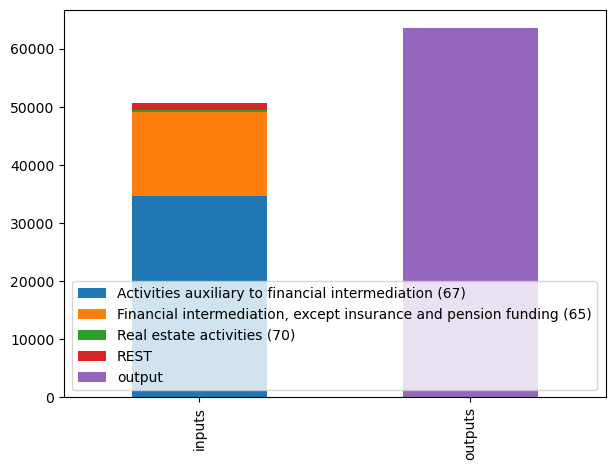

In [29]:
input_output.T.plot.bar(stacked=True).legend(loc='lower center')
plt.tight_layout()

In [30]:
# À quoi correspond la différence entre la consommation et la production de ce secteur ?
io.x.loc[secteur_financier] - io.Z[secteur_financier].sum()

indout    12842.117584
Name: (LU, Financial intermediation, except insurance and pension funding (65)), dtype: float64

La différence entre les deux valeurs, 12.8 milliards d'euros, équivaut aux taxes, à la masse salariale, et aux profits.

Ces valeurs sont contenues dans les (9) premières lignes de la matrice des comptes "satellites" (considérés comme extérieurs à l'économie marchande), qui est décrite plus bas. Pour information, on retrouve bien cette différence ici.

In [31]:
io.satellite.F[secteur_financier][:9].sum()

12842.1175958972

In [32]:
io.satellite.F[secteur_financier][:9]

stressor
Taxes less subsidies on products purchased: Total                                                 300.704341
Other net taxes on production                                                                     755.171567
Compensation of employees; wages, salaries, & employers' social contributions: Low-skilled         14.378997
Compensation of employees; wages, salaries, & employers' social contributions: Medium-skilled    1113.460326
Compensation of employees; wages, salaries, & employers' social contributions: High-skilled      2490.300813
Operating surplus: Consumption of fixed capital                                                   142.792375
Operating surplus: Rents on land                                                                    0.000000
Operating surplus: Royalties on resources                                                           0.000000
Operating surplus: Remaining net operating surplus                                               8025.309175
Name: (LU,

### A: coefficients de consommation intermédiaire
La matrice `A` contient les coefficients de consommation intermédiaire, en €/€.

Elle est calculée en "divisant" les transactions annuelles de $Z$ par la production totale $x$, formellement $A = Z\hat{x}^{-1}$.

In [33]:
# On peut vérifier que diviser Z par x donne bien la même chose que le contenu de A

io.Z.div(io.x['indout'], axis=1).head()

# a.div(b, axis=1) = division de a par b le long de l'axe 1 (colonnes)
# .head() = premières lignes (5) de la table

region                                                               AT  \
sector                                        Cultivation of paddy rice   
region sector                                                             
AT     Cultivation of paddy rice                                    NaN   
       Cultivation of wheat                                         NaN   
       Cultivation of cereal grains nec                             NaN   
       Cultivation of vegetables, fruit, nuts                       NaN   
       Cultivation of oil seeds                                     NaN   

region                                                              \
sector                                        Cultivation of wheat   
region sector                                                        
AT     Cultivation of paddy rice                          0.000000   
       Cultivation of wheat                               0.033135   
       Cultivation of cereal grains nec                   0.000000   
       Cultivation of vegetables, fruit, nuts             0.000000   
       Cultivation of oil seeds                           0.000000   

region                                                                          \
sector                                        Cultivation of cereal grains nec   
region sector                                                                    
AT     Cultivation of paddy rice                                      0.000000   
       Cultivation of wheat                                           0.000000   
       Cultivation of cereal grains nec                               0.014346   
       Cultivation of vegetables, fruit, nuts                         0.000000   
       Cultivation of oil seeds                                       0.000000   

region                                                                                \
sector                                        Cultivation of vegetables, fruit, nuts   
region sector                                                                          
AT     Cultivation of paddy rice                                             0.00000   
       Cultivation of wheat                                                  0.00000   
       Cultivation of cereal grains nec                                      0.00000   
       Cultivation of vegetables, fruit, nuts                                0.06819   
       Cultivation of oil seeds                                              0.00000   

region                                                                  \
sector                                        Cultivation of oil seeds   
region sector                                                            
AT     Cultivation of paddy rice                               0.00000   
       Cultivation of wheat                                    0.00000   
       Cultivation of cereal grains nec                        0.00000   
       Cultivation of vegetables, fruit, nuts                  0.00000   
       Cultivation of oil seeds                                0.00303   

region                                                                               \
sector                                        Cultivation of sugar cane, sugar beet   
region sector                                                                         
AT     Cultivation of paddy rice                                                0.0   
       Cultivation of wheat                                                     0.0   
       Cultivation of cereal grains nec                                         0.0   
       Cultivation of vegetables, fruit, nuts                                   0.0   
       Cultivation of oil seeds                                                 0.0   

region                                                                           \
sector                                        Cultivation of plant-based fibers   
region sector       

In [34]:
io.A.head()

region                                                               AT  \
sector                                        Cultivation of paddy rice   
region sector                                                             
AT     Cultivation of paddy rice                                      0   
       Cultivation of wheat                                           0   
       Cultivation of cereal grains nec                               0   
       Cultivation of vegetables, fruit, nuts                         0   
       Cultivation of oil seeds                                       0   

region                                                              \
sector                                        Cultivation of wheat   
region sector                                                        
AT     Cultivation of paddy rice                          0.000000   
       Cultivation of wheat                               0.033135   
       Cultivation of cereal grains nec                   0.000000   
       Cultivation of vegetables, fruit, nuts             0.000000   
       Cultivation of oil seeds                           0.000000   

region                                                                          \
sector                                        Cultivation of cereal grains nec   
region sector                                                                    
AT     Cultivation of paddy rice                                      0.000000   
       Cultivation of wheat                                           0.000000   
       Cultivation of cereal grains nec                               0.014346   
       Cultivation of vegetables, fruit, nuts                         0.000000   
       Cultivation of oil seeds                                       0.000000   

region                                                                                \
sector                                        Cultivation of vegetables, fruit, nuts   
region sector                                                                          
AT     Cultivation of paddy rice                                             0.00000   
       Cultivation of wheat                                                  0.00000   
       Cultivation of cereal grains nec                                      0.00000   
       Cultivation of vegetables, fruit, nuts                                0.06819   
       Cultivation of oil seeds                                              0.00000   

region                                                                  \
sector                                        Cultivation of oil seeds   
region sector                                                            
AT     Cultivation of paddy rice                               0.00000   
       Cultivation of wheat                                    0.00000   
       Cultivation of cereal grains nec                        0.00000   
       Cultivation of vegetables, fruit, nuts                  0.00000   
       Cultivation of oil seeds                                0.00303   

region                                                                               \
sector                                        Cultivation of sugar cane, sugar beet   
region sector                                                                         
AT     Cultivation of paddy rice                                                0.0   
       Cultivation of wheat                                                     0.0   
       Cultivation of cereal grains nec                                         0.0   
       Cultivation of vegetables, fruit, nuts                                   0.0   
       Cultivation of oil seeds                                                 0.0   

region                                                                           \
sector                                        Cultivation of plant-based fibers   
region sector       

Quels sont les secteurs principaux composant les dépenses du secteur de l'électricité au charbon en Allemagne en 2019?

In [35]:
secteur_elec_charbon = ('DE','Production of electricity by coal')

In [36]:
io.A[secteur_elec_charbon].nlargest(10)

region  sector                                                                             
DE      Manufacture of gas; distribution of gaseous fuels through mains                        0.155498
        Mining of coal and lignite; extraction of peat (10)                                    0.148468
        Other land transport                                                                   0.029307
RU      Mining of coal and lignite; extraction of peat (10)                                    0.026134
DE      Construction (45)                                                                      0.023028
        Other business activities (74)                                                         0.019250
US      Mining of coal and lignite; extraction of peat (10)                                    0.018018
DE      Sea and coastal water transport                                                        0.017811
        Manufacture of electrical machinery and apparatus n.e.c. (31)       

Par euro d'électricité produite, le secteur de l'électricité au charbon en Allemagne dépense .16€ en gaz, .15€ en extraction de charbon allemand (.026€ et .018€ de charbon russe et américain respectivement), .029€ en transport, etc.

### Comptes satellites
Les matrices des comptes satellites sont les homologues de Z (et A), mais en termes de facteurs de production, de valeur ajoutée, et d'émissions de substances.

In [ ]:
# Par 